# Expectation-maximization algorithm

In this assignment, we will derive and implement formulas for Gaussian Mixture Model — one of the most commonly used methods for performing soft clustering of the data. 

### Installation

We will need ```numpy```, ```scikit-learn```, ```matplotlib``` libraries for this assignment

In [233]:
import numpy as np
from numpy.linalg import slogdet, det, solve
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_digits
from grader import Grader
%matplotlib inline

### Grading
We will create a grader instance below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to the platform only after running submitting function in the last part of this assignment. If you want to make a partial submission, you can run that cell anytime you want.

In [234]:
grader = Grader()

## Implementing EM for GMM

For debugging we will use samples from gaussian mixture model with unknown mean, variance and priors. We also added inital values of parameters for grading purposes.

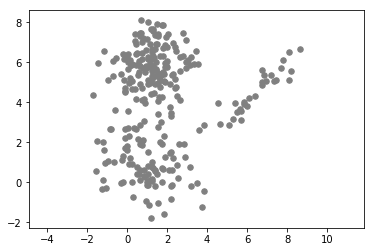

In [235]:
samples = np.load('samples.npz')
X = samples['data']
pi0 = samples['pi0']
mu0 = samples['mu0']
sigma0 = samples['sigma0']
plt.scatter(X[:, 0], X[:, 1], c='grey', s=30)
plt.axis('equal')
plt.show()

### Reminder

Remember, that EM algorithm is a coordinate descent optimization of variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{P(X, T|\theta)}{q(T)}dT\to \max$.

<b>E-step</b>:<br>
$\mathcal{L}(\theta, q) \to \max\limits_{q} \Leftrightarrow \mathcal{KL} [q(T) \,\|\, p(T|X, \theta)] \to \min \limits_{q\in Q} \Rightarrow q(T) = p(T|X, \theta)$<br>
<b>M-step</b>:<br> 
$\mathcal{L}(\theta, q) \to \max\limits_{\theta} \Leftrightarrow \mathbb{E}_{q(T)}\log p(X,T | \theta) \to \max\limits_{\theta}$

For GMM, $\theta$ is a set of parameters that consists of mean vectors $\mu_c$, covariance matrices $\Sigma_c$ and priors $\pi_c$ for each component.

Latent variables $T$ are indices of components to which each data point is assigned. $T_i$ (cluster index for object $i$) is a binary vector with only one active bit in position corresponding to the true component. For example, if we have $C=3$ components and object $i$ lies in first component, $T_i = [1, 0, 0]$.

The joint distribution can be written as follows: $p(T, X \mid \theta) =  \prod\limits_{i=1}^N p(T_i, X_i \mid \theta) = \prod\limits_{i=1}^N \prod\limits_{c=1}^C [\pi_c \mathcal{N}(X_i \mid \mu_c, \Sigma_c)]^{T_{ic}}$.

### E-step
In this step we need to estimate the posterior distribution over the latent variables with fixed values of parameters: $q(T) = p(T|X, \theta)$. We will assume that $T_i$ (cluster index for object $i$) is a binary vector with only one '1' in position corresponding to the true component. To do so we need to compute $\gamma_{ic} = P(T_{ic} = 1 \mid X, \theta)$. Note that $\sum\limits_{c=1}^C\gamma_{ic}=1$.


<b>Important trick 1:</b> It is important to avoid numerical errors. At some point you will have to compute the formula of the following form: $\frac{e^{x_i}}{\sum_j e^{x_j}}$. When you compute exponents of large numbers, you get huge numerical errors (some numbers will simply become infinity). You can avoid this by dividing numerator and denominator by $e^{\max(x)}$: $\frac{e^{x_i-\max(x)}}{\sum_j e^{x_j - \max(x)}}$. After this transformation maximum value in the denominator will be equal to one. All other terms will contribute smaller values. This trick is called log-sum-exp. So, to compute desired formula you first subtract maximum value from each component in vector $X$ and then compute everything else as before.

<b>Important trick 2:</b> You will probably need to compute formula of the form $A^{-1}x$ at some point. You would normally inverse $A$ and then multiply it by $x$. A bit faster and more numerically accurate way to do this is to solve the equation $Ay = x$. Its solution is $y=A^{-1}x$, but the equation $Ay = x$ can be solved by Gaussian elimination procedure. You can use ```np.linalg.solve``` for this.

<b>Other usefull functions: </b> <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.slogdet.html">```slogdet```</a> and <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.det.html#numpy.linalg.det">```det```</a>

<b>Task 1:</b> Implement E-step for GMM using template below.

In [236]:
from scipy.stats import multivariate_normal as mvn

def E_step(X, pi, mu, sigma):
    """
    Performs E-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    pi: (C), mixture component weights 
    mu: (C x d), mixture component means
    sigma: (C x d x d), mixture component covariance matrices
    
    Returns:
    gamma: (N x C), probabilities of clusters for objects
    """
    N = X.shape[0] # number of objects
    C = pi.shape[0] # number of clusters
    d = mu.shape[1] # dimension of each object
    gamma = np.zeros((N, C)) # distribution q(T)
    
    g     = np.zeros((N, C)) 
    for i in range(N):
        for c in range(C):
            g[i,c]=pi[c]*mvn(mu[c],sigma[c]).pdf(X[i])
    for i in range(N):
        norm=sum(g[i]);
        for c in range(C):
            gamma[i,c]=g[i,c]/norm;
    
    return gamma

print('X      shape ' , X.shape      )
print('pi0    shape ' , pi0.shape    )
print('mu0    shape ' , mu0.shape    )
print('sigma0 shape ' , sigma0.shape )


gamma = E_step(X, pi0, mu0, sigma0);


X      shape  (280, 2)
pi0    shape  (3,)
mu0    shape  (3, 2)
sigma0 shape  (3, 2, 2)


In [237]:
gamma = E_step(X, pi0, mu0, sigma0)
grader.submit_e_step(gamma)

Current answer for task Task 1 (E-step) is: 0.533717874108


### M-step

In M-step we need to maximize $\mathbb{E}_{q(T)}\log p(X,T | \theta)$ with respect to $\theta$. In our model this means that we need to find optimal values of $\pi$, $\mu$, $\Sigma$. To do so, you need to compute the derivatives and 
set them to zero. You should start by deriving formulas for $\mu$ as it is the easiest part. Then move on to $\Sigma$. Here it is crucial to optimize function w.r.t. to $\Lambda = \Sigma^{-1}$ and then inverse obtained result. Finaly, to compute $\pi$, you will need <a href="https://www3.nd.edu/~jstiver/FIN360/Constrained%20Optimization.pdf">Lagrange Multipliers technique</a> to satisfy constraint $\sum\limits_{i=1}^{n}\pi_i = 1$.

<br>
<b>Important note:</b> You will need to compute derivatives of scalars with respect to matrices. To refresh this technique from previous courses, see <a href="https://en.wikipedia.org/wiki/Matrix_calculus"> wiki article</a> about it . Main formulas of matrix derivatives can be found in <a href="http://www2.imm.dtu.dk/pubdb/views/edoc_download.php/3274/pdf/imm3274.pdf">Chapter 2 of The Matrix Cookbook</a>. For example, there you may find that $\frac{\partial}{\partial A}\log |A| = A^{-T}$.


<b>Task 2:</b> Implement M-step for GMM using template below.

In [238]:
from numpy import matmul
def M_step(X, gamma):
    """
    Performs M-step on GMM model
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    
    Returns:
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    d = X.shape[1] # dimension of each object

    ### YOUR CODE HERE
    pi = np.zeros((C))
    mu = np.zeros((C,d))
    sigma = np.zeros((C,d,d))
    
    # calc pi vec
    for c in range(C):
        pi[c]=sum(gamma[:,c])/N
    
    # Calc mu matrix
    for c in range(C):
        for j in range(d):
            upper_sum = 0;
            lower_sum = 0;
            for i in range(N):
                upper_sum +=X[i,j]*gamma[i,c];
                lower_sum += gamma[i,c];
            mu[c,j] = upper_sum / lower_sum;
    
    # calc sigma tensor
    for c in range(C):
        upper_sum = 0;
        lower_sum = 0;
        for i in range(N):
            x_shift = np.matrix(X[i]-mu[c]) # [d,]*[d,]T=scalar
            prod = matmul(x_shift.T,x_shift);
            upper_sum += gamma[i,c]*prod
            lower_sum += gamma[i,c];
        sigma[c] = upper_sum / lower_sum;
            
        
    
    

    return pi, mu, sigma

In [239]:
gamma = E_step(X, pi0, mu0, sigma0)
pi, mu, sigma = M_step(X, gamma)
grader.submit_m_step(pi, mu, sigma)

Current answer for task Task 2 (M-step: mu) is: 2.89939188205
Current answer for task Task 2 (M-step: sigma) is: 5.9771052169
Current answer for task Task 2 (M-step: pi) is: 0.550762445922


### Loss function

Finally, we need some function to track convergence. We will use variational lower bound $\mathcal{L}$ for this purpose. We will stop our EM iterations when $\mathcal{L}$ will saturate. Usually, you will need only about 10-20 iterations to converge. It is also useful to check that this function never decreases during training. If it does, you have a bug in your code.

<b>Task 3:</b> Implement a function that will compute $\mathcal{L}$ using template below.

$$\mathcal{L} = \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] (\log \pi_k + \log \mathcal{N}(x_n | \mu_k, \sigma_k)) - \sum_{n=1}^{N} \sum_{k=1}^{K} \mathbb{E}[z_{n, k}] \log \mathbb{E}[z_{n, k}]$$

In [240]:
def compute_vlb(X, pi, mu, sigma, gamma):
    """
    Each input is numpy array:
    X: (N x d), data points
    gamma: (N x C), distribution q(T)  
    pi: (C)
    mu: (C x d)
    sigma: (C x d x d)
    
    Returns value of variational lower bound
    """
    N = X.shape[0] # number of objects
    C = gamma.shape[1] # number of clusters
    D = X.shape[1] # dimension of each object
    loss = 0;
    for c in range(C):
        lg_pi =np.log(pi[c])
        for n in range(N):
            loss+=(np.log(mvn(mu[c],sigma[c]).pdf(X[n])+(1E-9))+lg_pi)*gamma[n,c]
    for c in range(C):
        for n in range(N):
            loss-=(np.log(gamma[n,c]))*gamma[n,c]
 
    
    ### YOUR CODE HERE

    return loss

In [241]:
pi, mu, sigma = pi0, mu0, sigma0
gamma = E_step(X, pi, mu, sigma)
pi, mu, sigma = M_step(X, gamma)
loss = compute_vlb(X, pi, mu, sigma, gamma)
grader.submit_VLB(loss)

Current answer for task Task 3 (VLB) is: -1213.97284148


### Bringing it all together

Now that we have E step, M step and VLB, we can implement training loop. We will start at random values of $\pi$, $\mu$ and $\Sigma$, train until $\mathcal{L}$ stops changing and return the resulting points. We also know that EM algorithm sometimes stops at local optima. To avoid this we should restart algorithm multiple times from different starting positions. Each training trial should stop either when maximum number of iterations is reached or when relative improvement is smaller than given tolerance ($|\frac{\mathcal{L}_i-\mathcal{L}_{i-1}}{\mathcal{L}_{i-1}}| \le \text{rtol}$).

Remember, that values of $\pi$ that you generate must be non-negative and sum up to 1. Also, $\Sigma$ matrices must be symmetric and positive semi-definite. If you don't know how to generate those matrices, you can use $\Sigma=I$ as initialization.

You will also sometimes get numerical errors because of component collapsing. The easiest way to deal with this problems is to simply restart the procedure.

<b>Task 4:</b> Implement training procedure

In [257]:

def random_pi(C,noise_sigma=0.1):
    pi = np.ones(C);
    pi += noise_sigma * np.random.randn(C);
    pi = np.abs(pi)
    pi /= sum(pi)
    return pi

def random_sigma(C,d,noise_sigma=0.1):
    sigma = np.zeros((C,d,d));
    for c in range(C):
        vec_ones = np.ones((d))+noise_sigma*np.random.randn(d);
        sigma[c] = np.diag(vec_ones)
    return sigma
def random_mu(X,C, noise_mu):
    N=X.shape[0]
    d=X.shape[1]
    mu = np.zeros((C,d));
    for c in range(C):
        idx = np.random.randint(N)
        mu[c] = X[idx]
    mu+=noise_mu*np.random.randn(d);
    
    return mu

def init_params(X, C=3, noise_pi=0,noise_mu=0,noise_sigma=0):
    pi    = random_pi(C,noise_pi);
    mu    = random_mu(X,C,noise_mu)
    sigma = random_sigma(C,X.shape[1],noise_sigma)
    return pi,mu,sigma

init_params(X,3,noise_pi=0.1,noise_sigma=0.1,noise_mu=20)


(array([ 0.31868802,  0.30984172,  0.37147026]),
 array([[  3.8862452 ,  18.33517952],
        [ -2.2393072 ,  18.44052856],
        [ -2.16890686,  19.00404412]]),
 array([[[ 0.91169125,  0.        ],
         [ 0.        ,  0.83450142]],
 
        [[ 0.99442522,  0.        ],
         [ 0.        ,  0.92536633]],
 
        [[ 0.83738735,  0.        ],
         [ 0.        ,  1.03373135]]]))

In [275]:
def train_EM(X, C, rtol=1e-3, max_iter=100, restarts=10):
    '''
    Starts with random initialization *restarts* times
    Runs optimization until saturation with *rtol* reached
    or *max_iter* iterations were made.
    
    X: (N, d), data points
    C: int, number of clusters
    '''
    N = X.shape[0] # number of objects
    d = X.shape[1] # dimension of each object
    best_loss = None
    best_pi = None
    best_mu = None
    best_sigma = None
    best_loss = -10E9;
    for R in range(restarts):
        try:
            pi, mu, sigma = init_params(X,C,noise_pi=0.1,noise_sigma=0.1,noise_mu=1)
            dloss = 0;
            
            for i in range(max_iter):
                gamma = E_step(X, pi, mu, sigma)
                pi, mu, sigma = M_step(X, gamma)
                loss = compute_vlb(X, pi, mu, sigma, gamma)
                print('Run %d Converged on %d iteration with loss %2.4f'%(R,i,loss))
                if ( abs(dloss-loss)<rtol):
                    print('Run %d Converged on %d iteration with loss %2.4f'%(R,i,loss))
                    break
                else:
                    dloss=loss;
                    
            if (loss>best_loss):
                print('Last Loss %2.4f -> New loss %2.4f'%(best_loss,loss))
                best_loss, best_pi, best_mu, best_sigma = loss,pi, mu, sigma
                
        except np.linalg.LinAlgError:
            print("Singular matrix: components collapsed")
            pass

    return best_loss, best_pi, best_mu, best_sigma

train_EM(X, 3, rtol=1e-3, max_iter=100, restarts=10)

Run 0 Converged on 0 iteration with loss -1158.5753
Run 0 Converged on 1 iteration with loss -1150.9772
Run 0 Converged on 2 iteration with loss -1144.9711
Run 0 Converged on 3 iteration with loss -1137.3443
Run 0 Converged on 4 iteration with loss -1128.3687
Run 0 Converged on 5 iteration with loss -1119.7795
Run 0 Converged on 6 iteration with loss -1113.1049
Run 0 Converged on 7 iteration with loss -1108.5673
Run 0 Converged on 8 iteration with loss -1105.6048
Run 0 Converged on 9 iteration with loss -1103.6055
Run 0 Converged on 10 iteration with loss -1102.1399
Run 0 Converged on 11 iteration with loss -1100.9528
Run 0 Converged on 12 iteration with loss -1099.8958
Run 0 Converged on 13 iteration with loss -1098.8715
Run 0 Converged on 14 iteration with loss -1097.8004
Run 0 Converged on 15 iteration with loss -1096.6048
Run 0 Converged on 16 iteration with loss -1095.2009
Run 0 Converged on 17 iteration with loss -1093.4760
Run 0 Converged on 18 iteration with loss -1091.2025
Run

(-1063.8116025361471,
 array([ 0.34158077,  0.55105489,  0.10736434]),
 array([[ 0.92077626,  0.96470503],
        [ 1.22298257,  5.82921127],
        [ 6.2946059 ,  4.42968431]]),
 array([[[ 1.49850233, -0.37363807],
         [-0.37363807,  1.42522155]],
 
        [[ 0.94368838,  0.06749004],
         [ 0.06749004,  1.10842364]],
 
        [[ 1.71350733,  1.39505134],
         [ 1.39505134,  1.32533639]]]))

In [267]:
best_loss, best_pi, best_mu, best_sigma = train_EM(X, 3)
grader.submit_EM(best_loss)

Run 0 Converged on 0 iteration with loss -1168.2470
Run 0 Converged on 1 iteration with loss -1162.6116
Run 0 Converged on 2 iteration with loss -1161.4789
Run 0 Converged on 3 iteration with loss -1160.7332
Run 0 Converged on 4 iteration with loss -1160.2741
Run 0 Converged on 5 iteration with loss -1160.0165
Run 0 Converged on 6 iteration with loss -1159.8784
Run 0 Converged on 7 iteration with loss -1159.8036
Run 0 Converged on 8 iteration with loss -1159.7596
Run 0 Converged on 9 iteration with loss -1159.7296
Run 0 Converged on 10 iteration with loss -1159.7054
Run 0 Converged on 11 iteration with loss -1159.6833
Run 0 Converged on 12 iteration with loss -1159.6614
Run 0 Converged on 13 iteration with loss -1159.6389
Run 0 Converged on 14 iteration with loss -1159.6152
Run 0 Converged on 15 iteration with loss -1159.5901
Run 0 Converged on 16 iteration with loss -1159.5637
Run 0 Converged on 17 iteration with loss -1159.5359
Run 0 Converged on 18 iteration with loss -1159.5068
Run

Run 3 Converged on 0 iteration with loss -1141.7737
Run 3 Converged on 1 iteration with loss -1087.1601
Run 3 Converged on 2 iteration with loss -1077.0430
Run 3 Converged on 3 iteration with loss -1069.7918
Run 3 Converged on 4 iteration with loss -1066.7834
Run 3 Converged on 5 iteration with loss -1065.5136
Run 3 Converged on 6 iteration with loss -1064.7234
Run 3 Converged on 7 iteration with loss -1064.2126
Run 3 Converged on 8 iteration with loss -1063.9515
Run 3 Converged on 9 iteration with loss -1063.8531
Run 3 Converged on 10 iteration with loss -1063.8233
Run 3 Converged on 11 iteration with loss -1063.8150
Run 3 Converged on 12 iteration with loss -1063.8125
Run 3 Converged on 13 iteration with loss -1063.8117
-------------- Converged ---------
Run 4 Converged on 0 iteration with loss -1166.5913
Run 4 Converged on 1 iteration with loss -1129.1588
Run 4 Converged on 2 iteration with loss -1097.6225
Run 4 Converged on 3 iteration with loss -1093.4077
Run 4 Converged on 4 iter

Run 8 Converged on 23 iteration with loss -1063.8248
Run 8 Converged on 24 iteration with loss -1063.8157
Run 8 Converged on 25 iteration with loss -1063.8129
Run 8 Converged on 26 iteration with loss -1063.8119
-------------- Converged ---------
Run 9 Converged on 0 iteration with loss -1068.6853
Run 9 Converged on 1 iteration with loss -1065.0797
Run 9 Converged on 2 iteration with loss -1064.1686
Run 9 Converged on 3 iteration with loss -1063.8909
Run 9 Converged on 4 iteration with loss -1063.8286
Run 9 Converged on 5 iteration with loss -1063.8151
Run 9 Converged on 6 iteration with loss -1063.8121
Run 9 Converged on 7 iteration with loss -1063.8114
-------------- Converged ---------
Last Loss -1063.8116 -> New loss -1063.8114
Current answer for task Task 4 (EM) is: -1063.81144066


If you implemented all the steps correctly, your algorithm should converge in about 20 iterations. Let's plot the clusters to see it. We will assign a cluster label as the most probable cluster index. This can be found using matrix $\gamma$ computed on last E-step. 


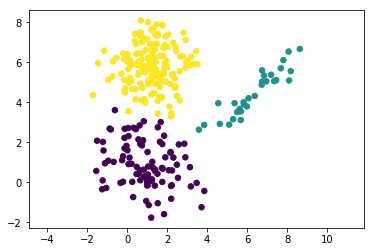

In [268]:
gamma = E_step(X, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

In [281]:

x_grid = [[0,0][0,1];[0,2]]
gamma  = E_step(x_grid, best_pi, best_mu, best_sigma)
labels = gamma.argmax(1)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=30)
plt.axis('equal')
plt.show()

SyntaxError: invalid syntax (<ipython-input-281-c6492905e82b>, line 2)

### Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and your token into variables below. You can generate the token on this programming assignment page. <b>Note:</b> Token expires 30 minutes after generation.

In [271]:
STUDENT_EMAIL = 'const.vin@gmail.com'
STUDENT_TOKEN ='mDoqy5uew3xSZh5n'
grader.status()

You want to submit these numbers:
Task Task 1 (E-step): 0.533717874108
Task Task 2 (M-step: mu): 2.89939188205
Task Task 2 (M-step: sigma): 5.9771052169
Task Task 2 (M-step: pi): 0.550762445922
Task Task 3 (VLB): -1213.97284148
Task Task 4 (EM): -1063.81144066


If you want to submit these answers, run cell below

In [272]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
